### Your very own neural network

In this notebook, we're going to build a neural network using naught but pure numpy and steel nerves. It's going to be fun, I promise!

![img](https://s27.postimg.org/vpui4r5n7/cartoon-2029952_960_720.png)

In [2]:
import itertools

In [3]:
# use the preloaded keras datasets and models
! mkdir -p ~/.keras/datasets
! mkdir -p ~/.keras/models
! ln -s $(realpath ../readonly/keras/datasets/*) ~/.keras/datasets/
! ln -s $(realpath ../readonly/keras/models/*) ~/.keras/models/

ln: failed to create symbolic link '/home/yuri/.keras/datasets/cifar-10-batches-py.tar.gz': File exists
ln: failed to create symbolic link '/home/yuri/.keras/datasets/mnist.npz': File exists
ln: failed to create symbolic link '/home/yuri/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5': File exists


In [4]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

Here goes our main class: a layer that can .forward() and .backward().

In [5]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [6]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.maximum>
        return np.maximum(0, input)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output * relu_grad        

In [7]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

#### Instant primer: lambda functions

In python, you can define functions in one line using the `lambda` syntax: `lambda param1, param2: expression`

For example: `f = lambda x, y: x+y` is equivalent to a normal function:

```
def f(x,y):
    return x+y
```
For more information, click [here](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [8]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return input.dot(self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = grad_output.dot(self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for W and b as __sum of gradients over batch__, not mean over gradients. Grad_output is already divided by batch size.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [9]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [10]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [11]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [160]:
def softmax1(logits, axis=1):
    '''unstable softmax'''
    
    exps = np.exp(logits)
    return exps / np.sum(exps, axis=axis, keepdims=True)

def softmax2(logits, axis=1):
    '''stable softmax'''
    
    exps = np.exp(logits - np.max(logits, axis=axis, keepdims=True))
    return exps / np.sum(exps, axis=axis, keepdims=True)

In [161]:
logits = np.linspace(-1, 500, 500).reshape([50, 10])
assert np.allclose(softmax1(logits), softmax2(logits)), "Softmaxes differ"

In [183]:
logits = np.linspace(-1, 5e5, 500).reshape([50, 10])
_ = softmax1(logits)
print(_[:3])

[[ 0. nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]


/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [182]:
_ = softmax2(logits)
print(_[:3])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [179]:
# softmax2 is stable version
softmax = softmax2

# last check
logits = np.linspace(-1, 5e5, 500).reshape([50, 10])
_ = softmax(logits)

Let't find a stable version of cross entropy

In [184]:
def softmax_crossentropy_with_logits1(logits, reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
   
    # this is unstable code. I experienced numerical over and under flows
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def softmax_crossentropy_with_logits2(logits, reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    
    proba = softmax(logits, axis=1)
    xentropy = -np.log(proba[range(len(logits)), reference_answers])
       
    return xentropy

def softmax_crossentropy_with_logits3(logits, reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
   
    # this is unstable code. I experienced numerical over and under flows
    logits = logits - logits.max(axis=1, keepdims=True
                                )
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

In [233]:
# check implementations are correct

logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10
loss1 = softmax_crossentropy_with_logits(logits, answers) 
loss2 = softmax_crossentropy_with_logits2(logits, answers)
loss3 = softmax_crossentropy_with_logits3(logits, answers)

assert np.allclose(loss1, loss2), "loss1 != loss2"
assert np.allclose(loss2, loss3), "loss2 != loss3"

In [234]:
# Test stability

logits = np.linspace(-1,1e5,500).reshape([50,10])
answers = np.arange(50)%10

In [235]:
print(softmax_crossentropy_with_logits1(logits, answers)[:3])

[inf inf inf]


/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


In [236]:
print(softmax_crossentropy_with_logits2(logits, answers)[:3])

[inf inf inf]


/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [237]:
print(softmax_crossentropy_with_logits3(logits, answers)[:3])

[1803.6252505  1603.22244489 1402.81963928]


In [256]:
# softmax_crossentropy_with_logits3 is stable version
softmax_crossentropy_with_logits = softmax_crossentropy_with_logits3

# last check
print(softmax_crossentropy_with_logits(logits, answers)[:3])

[1803.6252505  1603.22244489 1402.81963928]


Let't find a stable version of cross entropy gradient

In [257]:
def grad_softmax_crossentropy_with_logits1(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

def grad_softmax_crossentropy_with_logits2(logits, reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1
        
    return (softmax(logits) - ones_for_answers) / logits.shape[0]

In [226]:
# check implementations are correct

logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10
grad1 = grad_softmax_crossentropy_with_logits1(logits, answers)
grad2 = grad_softmax_crossentropy_with_logits2(logits, answers)

assert np.allclose(grad1, grad2), "grad1 != grad2"

In [244]:
# Test stability

logits = np.linspace(-1,1e5,500).reshape([50,10])
answers = np.arange(50)%10

In [247]:
print(grad_softmax_crossentropy_with_logits1(logits, answers)[:3])

[[-0.02  0.    0.    0.     nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]]


/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [250]:
print(grad_softmax_crossentropy_with_logits2(logits, answers)[:3])

[[-2.00000000e-002  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  1.58318655e-263  1.71145201e-176
   1.85010919e-089  2.00000000e-002]
 [ 0.00000000e+000 -2.00000000e-002  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  1.58318655e-263  1.71145201e-176
   1.85010919e-089  2.00000000e-002]
 [ 0.00000000e+000  0.00000000e+000 -2.00000000e-002  0.00000000e+000
   0.00000000e+000  0.00000000e+000  1.58318655e-263  1.71145201e-176
   1.85010919e-089  2.00000000e-002]]


In [253]:
# softmax_crossentropy_with_logits3 is stable version
grad_softmax_crossentropy_with_logits = grad_softmax_crossentropy_with_logits2

# last check
print(grad_softmax_crossentropy_with_logits(logits, answers)[:3])

[[-2.00000000e-002  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  1.58318655e-263  1.71145201e-176
   1.85010919e-089  2.00000000e-002]
 [ 0.00000000e+000 -2.00000000e-002  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  1.58318655e-263  1.71145201e-176
   1.85010919e-089  2.00000000e-002]
 [ 0.00000000e+000  0.00000000e+000 -2.00000000e-002  0.00000000e+000
   0.00000000e+000  0.00000000e+000  1.58318655e-263  1.71145201e-176
   1.85010919e-089  2.00000000e-002]]


In [231]:
# Checks from the original task
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

Using TensorFlow backend.


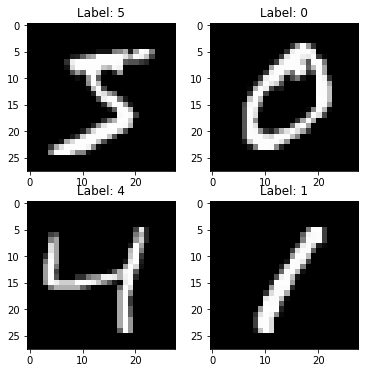

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [15]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [16]:
network

In [287]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    # <your code here>
    for layer in network:
        input = layer.forward(input)
        activations.append(input)
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # <your code: propagate gradients through the network>
    layer_inputs = layer_inputs[:-1]
    grad_output = loss_grad
    for layer, layer_input in reversed(list(zip(network,layer_inputs))):
        grad_output = layer.backward(layer_input, grad_output)
        
    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [18]:
from tqdm import trange
def titerate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [19]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [20]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 0.99998
Val accuracy: 0.9803


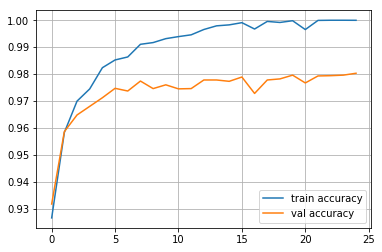

In [21]:
for epoch in range(25):

    for x_batch,y_batch in titerate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

### Peer-reviewed assignment

Congradulations, you managed to get this far! There is just one quest left undone, and this time you'll get to choose what to do.


#### Option I: initialization
* Implement Dense layer with Xavier initialization as explained [here](http://bit.ly/2vTlmaJ)

To pass this assignment, you must conduct an experiment showing how xavier initialization compares to default initialization on deep networks (5+ layers).


#### Option II: regularization
* Implement a version of Dense layer with L2 regularization penalty: when updating Dense Layer weights, adjust gradients to minimize

$$ Loss = Crossentropy + \alpha \cdot \underset i \sum {w_i}^2 $$

To pass this assignment, you must conduct an experiment showing if regularization mitigates overfitting in case of abundantly large number of neurons. Consider tuning $\alpha$ for better results.

#### Option III: optimization
* Implement a version of Dense layer that uses momentum/rmsprop or whatever method worked best for you last time.

Most of those methods require persistent parameters like momentum direction or moving average grad norm, but you can easily store those params inside your layers.

To pass this assignment, you must conduct an experiment showing how your chosen method performs compared to vanilla SGD.

### General remarks
_Please read the peer-review guidelines before starting this part of the assignment._

In short, a good solution is one that:
* is based on this notebook
* runs in the default course environment with Run All
* its code doesn't cause spontaneous eye bleeding
* its report is easy to read.

_Formally we can't ban you from writing boring reports, but if you bored your reviewer to death, there's noone left alive to give you the grade you want._


### Bonus assignments

As a bonus assignment (no points, just swag), consider implementing Batch Normalization ([guide](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)) or Dropout ([guide](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)). Note, however, that those "layers" behave differently when training and when predicting on test set.

* Dropout:
  * During training: drop units randomly with probability __p__ and multiply everything by __1/(1-p)__
  * During final predicton: do nothing; pretend there's no dropout
  
* Batch normalization
  * During training, it substracts mean-over-batch and divides by std-over-batch and updates mean and variance.
  * During final prediction, it uses accumulated mean and variance.


### Peer-reviewed assignments

#### Option I: initialization  

In [21]:
class Dense1(Layer):
    def __init__(self, input_units, output_units, initializer='xavier', learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate

        # initialize weights with small random numbers. 
        if initializer == 'normal':
            self.weights = np.random.randn(input_units, output_units) * 0.01
        elif initializer == 'xavier':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(2 / (input_units + output_units))
        else:
            raise ValueError('Wrong initializer parameter')
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return input.dot(self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        grad_input = grad_output.dot(self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [22]:
def build_and_train1(layer_sizes, initializer, lr, n_epochs):
    
    print('\nTraining with initializer = {} and lr = {} for n_epochs = {}'.format(initializer, lr, n_epochs))
    
    network = []
    network.append(Dense1(X_train.shape[1], layer_sizes[0], initializer, lr))
    network.append(ReLU())
    for layer in range(len(layer_sizes)-1):
        network.append(Dense1(layer_sizes[layer], layer_sizes[layer+1], initializer, lr))
        network.append(ReLU())
    network.append(Dense1(layer_sizes[-1], 10, initializer, lr))

    train_log = []
    val_log = []

    for epoch in range(n_epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
            train(network,x_batch,y_batch)

        train_log.append(np.mean(predict(network,X_train)==y_train))
        val_log.append(np.mean(predict(network,X_val)==y_val))    
        print('epoch = {:2d}, train acc = {:6.4f}, val acc = {:6.4f}'.format(epoch, train_log[-1], val_log[-1]))
        
    return train_log, val_log

def display_learning_curve1(ax, train_log, val_log, initializer, lr):
        
    ax.plot(train_log,label='train accuracy')
    ax.plot(val_log,label='val accuracy')
    ax.set_ylim(0.86, 1)
#     plt.legend(loc='best')
    ax.set_title('initializer = {}, lr = {}'.format(initializer, lr), fontsize=14)
    ax.text(0.5, 0.2, 'train acc = {:6.4f}\n   val acc = {:6.4f}'.format(train_log[-1], val_log[-1]),
            ha='left', va='bottom', fontsize=14, transform=ax.transAxes)
    ax.grid()


Training with initializer = normal and lr = 0.07 for n_epochs = 50
epoch =  0, train acc = 0.9028, val acc = 0.9095
epoch =  1, train acc = 0.9427, val acc = 0.9462
epoch =  2, train acc = 0.9642, val acc = 0.9614
epoch =  3, train acc = 0.9724, val acc = 0.9667
epoch =  4, train acc = 0.9783, val acc = 0.9690
epoch =  5, train acc = 0.9825, val acc = 0.9721
epoch =  6, train acc = 0.9809, val acc = 0.9690
epoch =  7, train acc = 0.9901, val acc = 0.9788
epoch =  8, train acc = 0.9908, val acc = 0.9775
epoch =  9, train acc = 0.9918, val acc = 0.9764
epoch = 10, train acc = 0.9938, val acc = 0.9787
epoch = 11, train acc = 0.9940, val acc = 0.9778
epoch = 12, train acc = 0.9941, val acc = 0.9750
epoch = 13, train acc = 0.9955, val acc = 0.9766
epoch = 14, train acc = 0.9966, val acc = 0.9783
epoch = 15, train acc = 0.9965, val acc = 0.9777
epoch = 16, train acc = 0.9986, val acc = 0.9775
epoch = 17, train acc = 0.9987, val acc = 0.9785
epoch = 18, train acc = 0.9980, val acc = 0.9768
e

epoch = 12, train acc = 0.9900, val acc = 0.9728
epoch = 13, train acc = 0.9890, val acc = 0.9701
epoch = 14, train acc = 0.9937, val acc = 0.9740
epoch = 15, train acc = 0.9857, val acc = 0.9656
epoch = 16, train acc = 0.9923, val acc = 0.9740
epoch = 17, train acc = 0.9942, val acc = 0.9723
epoch = 18, train acc = 0.9733, val acc = 0.9496
epoch = 19, train acc = 0.9935, val acc = 0.9745
epoch = 20, train acc = 0.9931, val acc = 0.9732
epoch = 21, train acc = 0.9949, val acc = 0.9729
epoch = 22, train acc = 0.9917, val acc = 0.9708
epoch = 23, train acc = 0.9952, val acc = 0.9739
epoch = 24, train acc = 0.9928, val acc = 0.9701
epoch = 25, train acc = 0.9931, val acc = 0.9702
epoch = 26, train acc = 0.9956, val acc = 0.9724
epoch = 27, train acc = 0.9887, val acc = 0.9690
epoch = 28, train acc = 0.9901, val acc = 0.9717
epoch = 29, train acc = 0.9951, val acc = 0.9738
epoch = 30, train acc = 0.9915, val acc = 0.9727
epoch = 31, train acc = 0.9939, val acc = 0.9730
epoch = 32, train ac

epoch = 26, train acc = 0.9987, val acc = 0.9789
epoch = 27, train acc = 0.9976, val acc = 0.9798
epoch = 28, train acc = 0.9984, val acc = 0.9799
epoch = 29, train acc = 0.9973, val acc = 0.9775
epoch = 30, train acc = 0.9980, val acc = 0.9793
epoch = 31, train acc = 0.9969, val acc = 0.9763
epoch = 32, train acc = 0.9983, val acc = 0.9788
epoch = 33, train acc = 0.9993, val acc = 0.9795
epoch = 34, train acc = 0.9997, val acc = 0.9814
epoch = 35, train acc = 0.9998, val acc = 0.9808
epoch = 36, train acc = 1.0000, val acc = 0.9809
epoch = 37, train acc = 1.0000, val acc = 0.9811
epoch = 38, train acc = 1.0000, val acc = 0.9813
epoch = 39, train acc = 1.0000, val acc = 0.9813
epoch = 40, train acc = 1.0000, val acc = 0.9815
epoch = 41, train acc = 1.0000, val acc = 0.9816
epoch = 42, train acc = 1.0000, val acc = 0.9816
epoch = 43, train acc = 1.0000, val acc = 0.9816
epoch = 44, train acc = 1.0000, val acc = 0.9817
epoch = 45, train acc = 1.0000, val acc = 0.9817
epoch = 46, train ac

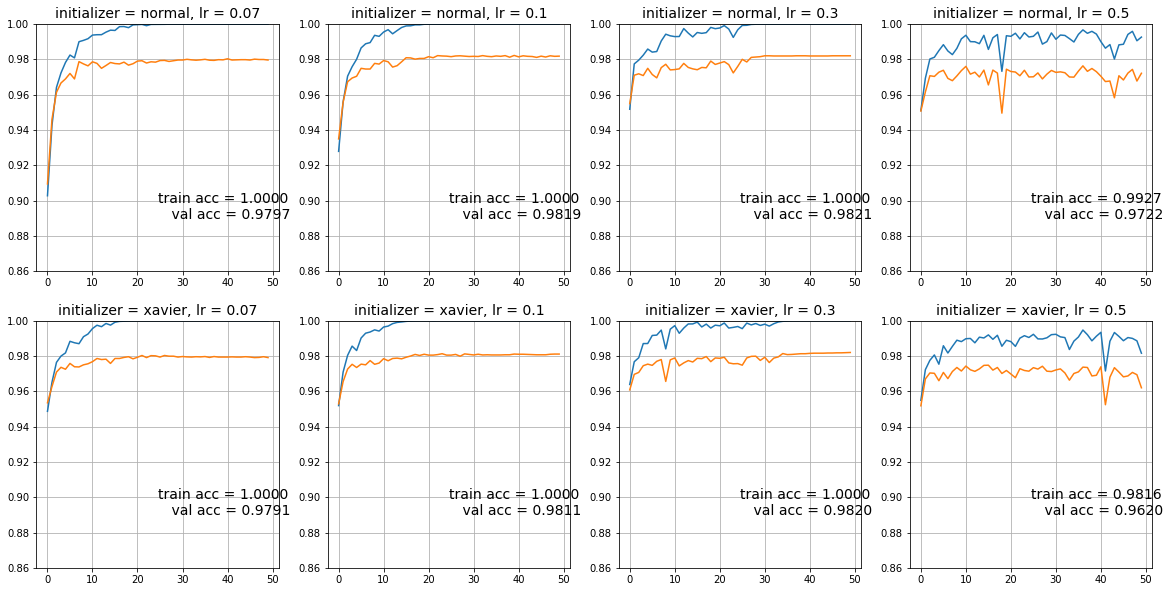

In [23]:
%%time
layer_sizes = [100, 200]

lrs = [0.07, 0.1, 0.3, 0.5]
initializers = ['normal', 'xavier']

n_epochs = 50


fig = plt.figure(figsize=(20, 10))
i = 0
for initializer, lr in itertools.product(initializers, lrs):
    i += 1
    train_log, val_log = build_and_train1(layer_sizes, initializer, lr, n_epochs)

    ax = plt.subplot(len(initializers), len(lrs), i) 
    display_learning_curve1(ax, train_log, val_log, initializer, lr)

For small network no noticeable improvemt is observed for any learning rate.

Let's try a bigger network


Training with initializer = normal and lr = 0.07 for n_epochs = 50
epoch =  0, train acc = 0.1136, val acc = 0.1064
epoch =  1, train acc = 0.1136, val acc = 0.1064
epoch =  2, train acc = 0.1136, val acc = 0.1064
epoch =  3, train acc = 0.1136, val acc = 0.1064
epoch =  4, train acc = 0.1136, val acc = 0.1064
epoch =  5, train acc = 0.1136, val acc = 0.1064
epoch =  6, train acc = 0.8792, val acc = 0.8856
epoch =  7, train acc = 0.9373, val acc = 0.9383
epoch =  8, train acc = 0.9674, val acc = 0.9586
epoch =  9, train acc = 0.9758, val acc = 0.9654
epoch = 10, train acc = 0.9812, val acc = 0.9676
epoch = 11, train acc = 0.9844, val acc = 0.9694
epoch = 12, train acc = 0.9811, val acc = 0.9667
epoch = 13, train acc = 0.9875, val acc = 0.9688
epoch = 14, train acc = 0.9879, val acc = 0.9698
epoch = 15, train acc = 0.9905, val acc = 0.9739
epoch = 16, train acc = 0.9933, val acc = 0.9733
epoch = 17, train acc = 0.9939, val acc = 0.9732
epoch = 18, train acc = 0.9941, val acc = 0.9740
e

epoch = 12, train acc = 0.1035, val acc = 0.1090
epoch = 13, train acc = 0.0990, val acc = 0.0967
epoch = 14, train acc = 0.1136, val acc = 0.1064
epoch = 15, train acc = 0.1020, val acc = 0.1030
epoch = 16, train acc = 0.0972, val acc = 0.0983
epoch = 17, train acc = 0.1136, val acc = 0.1064
epoch = 18, train acc = 0.0968, val acc = 0.1009
epoch = 19, train acc = 0.1020, val acc = 0.1030
epoch = 20, train acc = 0.0994, val acc = 0.0990
epoch = 21, train acc = 0.0968, val acc = 0.1009
epoch = 22, train acc = 0.1136, val acc = 0.1064
epoch = 23, train acc = 0.0994, val acc = 0.0990
epoch = 24, train acc = 0.1136, val acc = 0.1064
epoch = 25, train acc = 0.0972, val acc = 0.0983
epoch = 26, train acc = 0.0994, val acc = 0.0990
epoch = 27, train acc = 0.1035, val acc = 0.1090
epoch = 28, train acc = 0.1136, val acc = 0.1064
epoch = 29, train acc = 0.1035, val acc = 0.1090
epoch = 30, train acc = 0.0998, val acc = 0.0961
epoch = 31, train acc = 0.1136, val acc = 0.1064
epoch = 32, train ac

epoch = 26, train acc = 0.9979, val acc = 0.9788
epoch = 27, train acc = 0.9997, val acc = 0.9813
epoch = 28, train acc = 0.9997, val acc = 0.9810
epoch = 29, train acc = 0.9994, val acc = 0.9826
epoch = 30, train acc = 0.9979, val acc = 0.9781
epoch = 31, train acc = 0.9995, val acc = 0.9816
epoch = 32, train acc = 0.9933, val acc = 0.9798
epoch = 33, train acc = 1.0000, val acc = 0.9824
epoch = 34, train acc = 1.0000, val acc = 0.9824
epoch = 35, train acc = 0.9999, val acc = 0.9829
epoch = 36, train acc = 1.0000, val acc = 0.9828
epoch = 37, train acc = 0.9992, val acc = 0.9817
epoch = 38, train acc = 1.0000, val acc = 0.9833
epoch = 39, train acc = 1.0000, val acc = 0.9839
epoch = 40, train acc = 1.0000, val acc = 0.9839
epoch = 41, train acc = 1.0000, val acc = 0.9839
epoch = 42, train acc = 1.0000, val acc = 0.9839
epoch = 43, train acc = 1.0000, val acc = 0.9838
epoch = 44, train acc = 1.0000, val acc = 0.9838
epoch = 45, train acc = 1.0000, val acc = 0.9838
epoch = 46, train ac

/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


epoch = 20, train acc = 0.0986, val acc = 0.0991
epoch = 21, train acc = 0.0986, val acc = 0.0991
epoch = 22, train acc = 0.0986, val acc = 0.0991
epoch = 23, train acc = 0.0986, val acc = 0.0991
epoch = 24, train acc = 0.0986, val acc = 0.0991
epoch = 25, train acc = 0.0986, val acc = 0.0991
epoch = 26, train acc = 0.0986, val acc = 0.0991
epoch = 27, train acc = 0.0986, val acc = 0.0991
epoch = 28, train acc = 0.0986, val acc = 0.0991
epoch = 29, train acc = 0.0986, val acc = 0.0991
epoch = 30, train acc = 0.0986, val acc = 0.0991
epoch = 31, train acc = 0.0986, val acc = 0.0991
epoch = 32, train acc = 0.0986, val acc = 0.0991
epoch = 33, train acc = 0.0986, val acc = 0.0991
epoch = 34, train acc = 0.0986, val acc = 0.0991
epoch = 35, train acc = 0.0986, val acc = 0.0991
epoch = 36, train acc = 0.0986, val acc = 0.0991
epoch = 37, train acc = 0.0986, val acc = 0.0991
epoch = 38, train acc = 0.0986, val acc = 0.0991
epoch = 39, train acc = 0.0986, val acc = 0.0991
epoch = 40, train ac

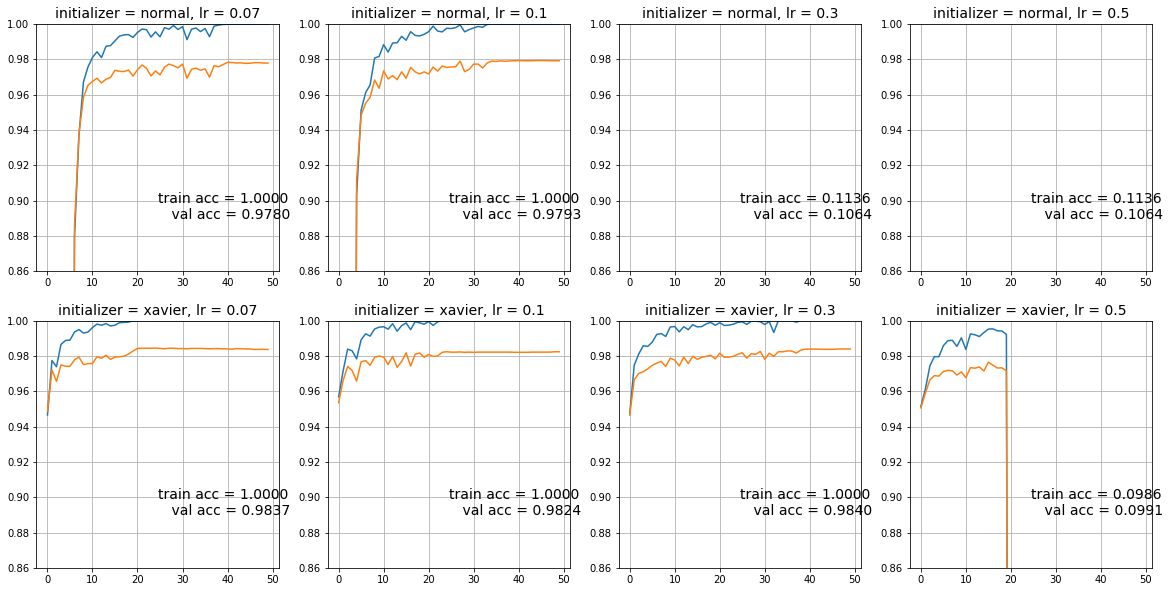

In [24]:
%%time
layer_sizes = [200] * 4

lrs = [0.07, 0.1, 0.3, 0.5]
initializers = ['normal', 'xavier']

n_epochs = 50


fig = plt.figure(figsize=(20, 10))
i = 0
for initializer, lr in itertools.product(initializers, lrs):
    i += 1
    train_log, val_log = build_and_train1(layer_sizes, initializer, lr, n_epochs)

    ax = plt.subplot(len(initializers), len(lrs), i) 
    display_learning_curve1(ax, train_log, val_log, initializer, lr)

For low learning rates networks learn faster and achieve a higher val accuracy when trained with Xavier initialization. 

For higher learning rates networks with 'normal' initialization simply do not learn at all, while networks with Xavier initialization exhibit very good perfomance (not considering network with highest learning rate where numerical overflow occured).

Let's try even bigger network!


Training with initializer = normal and lr = 0.07 for n_epochs = 50
epoch =  0, train acc = 0.1136, val acc = 0.1064
epoch =  1, train acc = 0.1136, val acc = 0.1064
epoch =  2, train acc = 0.1136, val acc = 0.1064
epoch =  3, train acc = 0.1136, val acc = 0.1064
epoch =  4, train acc = 0.1136, val acc = 0.1064
epoch =  5, train acc = 0.1136, val acc = 0.1064
epoch =  6, train acc = 0.1136, val acc = 0.1064
epoch =  7, train acc = 0.1136, val acc = 0.1064
epoch =  8, train acc = 0.1136, val acc = 0.1064
epoch =  9, train acc = 0.1020, val acc = 0.1030
epoch = 10, train acc = 0.1136, val acc = 0.1064
epoch = 11, train acc = 0.1136, val acc = 0.1064
epoch = 12, train acc = 0.1136, val acc = 0.1064
epoch = 13, train acc = 0.1136, val acc = 0.1064
epoch = 14, train acc = 0.1035, val acc = 0.1090
epoch = 15, train acc = 0.1136, val acc = 0.1064
epoch = 16, train acc = 0.1136, val acc = 0.1064
epoch = 17, train acc = 0.1136, val acc = 0.1064
epoch = 18, train acc = 0.1136, val acc = 0.1064
e

epoch = 12, train acc = 0.1035, val acc = 0.1090
epoch = 13, train acc = 0.1136, val acc = 0.1064
epoch = 14, train acc = 0.0972, val acc = 0.0983
epoch = 15, train acc = 0.1136, val acc = 0.1064
epoch = 16, train acc = 0.1136, val acc = 0.1064
epoch = 17, train acc = 0.1035, val acc = 0.1090
epoch = 18, train acc = 0.1136, val acc = 0.1064
epoch = 19, train acc = 0.1136, val acc = 0.1064
epoch = 20, train acc = 0.1020, val acc = 0.1030
epoch = 21, train acc = 0.1136, val acc = 0.1064
epoch = 22, train acc = 0.1035, val acc = 0.1090
epoch = 23, train acc = 0.0994, val acc = 0.0990
epoch = 24, train acc = 0.0994, val acc = 0.0990
epoch = 25, train acc = 0.1020, val acc = 0.1030
epoch = 26, train acc = 0.1136, val acc = 0.1064
epoch = 27, train acc = 0.0998, val acc = 0.0961
epoch = 28, train acc = 0.0990, val acc = 0.0967
epoch = 29, train acc = 0.1136, val acc = 0.1064
epoch = 30, train acc = 0.1136, val acc = 0.1064
epoch = 31, train acc = 0.1020, val acc = 0.1030
epoch = 32, train ac

epoch = 26, train acc = 0.9989, val acc = 0.9794
epoch = 27, train acc = 0.9993, val acc = 0.9794
epoch = 28, train acc = 0.9963, val acc = 0.9761
epoch = 29, train acc = 0.9991, val acc = 0.9811
epoch = 30, train acc = 0.9999, val acc = 0.9813
epoch = 31, train acc = 0.9983, val acc = 0.9794
epoch = 32, train acc = 0.9992, val acc = 0.9810
epoch = 33, train acc = 0.9996, val acc = 0.9805
epoch = 34, train acc = 0.9995, val acc = 0.9808
epoch = 35, train acc = 0.9990, val acc = 0.9800
epoch = 36, train acc = 0.9992, val acc = 0.9808
epoch = 37, train acc = 0.9986, val acc = 0.9799
epoch = 38, train acc = 0.9994, val acc = 0.9807
epoch = 39, train acc = 0.9997, val acc = 0.9806
epoch = 40, train acc = 0.9986, val acc = 0.9789
epoch = 41, train acc = 0.9997, val acc = 0.9810
epoch = 42, train acc = 0.9992, val acc = 0.9816
epoch = 43, train acc = 0.9999, val acc = 0.9806
epoch = 44, train acc = 0.9995, val acc = 0.9811
epoch = 45, train acc = 0.9995, val acc = 0.9803
epoch = 46, train ac

/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


epoch = 20, train acc = 0.0986, val acc = 0.0991
epoch = 21, train acc = 0.0986, val acc = 0.0991
epoch = 22, train acc = 0.0986, val acc = 0.0991
epoch = 23, train acc = 0.0986, val acc = 0.0991
epoch = 24, train acc = 0.0986, val acc = 0.0991
epoch = 25, train acc = 0.0986, val acc = 0.0991
epoch = 26, train acc = 0.0986, val acc = 0.0991
epoch = 27, train acc = 0.0986, val acc = 0.0991
epoch = 28, train acc = 0.0986, val acc = 0.0991
epoch = 29, train acc = 0.0986, val acc = 0.0991
epoch = 30, train acc = 0.0986, val acc = 0.0991
epoch = 31, train acc = 0.0986, val acc = 0.0991
epoch = 32, train acc = 0.0986, val acc = 0.0991
epoch = 33, train acc = 0.0986, val acc = 0.0991
epoch = 34, train acc = 0.0986, val acc = 0.0991
epoch = 35, train acc = 0.0986, val acc = 0.0991
epoch = 36, train acc = 0.0986, val acc = 0.0991
epoch = 37, train acc = 0.0986, val acc = 0.0991
epoch = 38, train acc = 0.0986, val acc = 0.0991
epoch = 39, train acc = 0.0986, val acc = 0.0991
epoch = 40, train ac

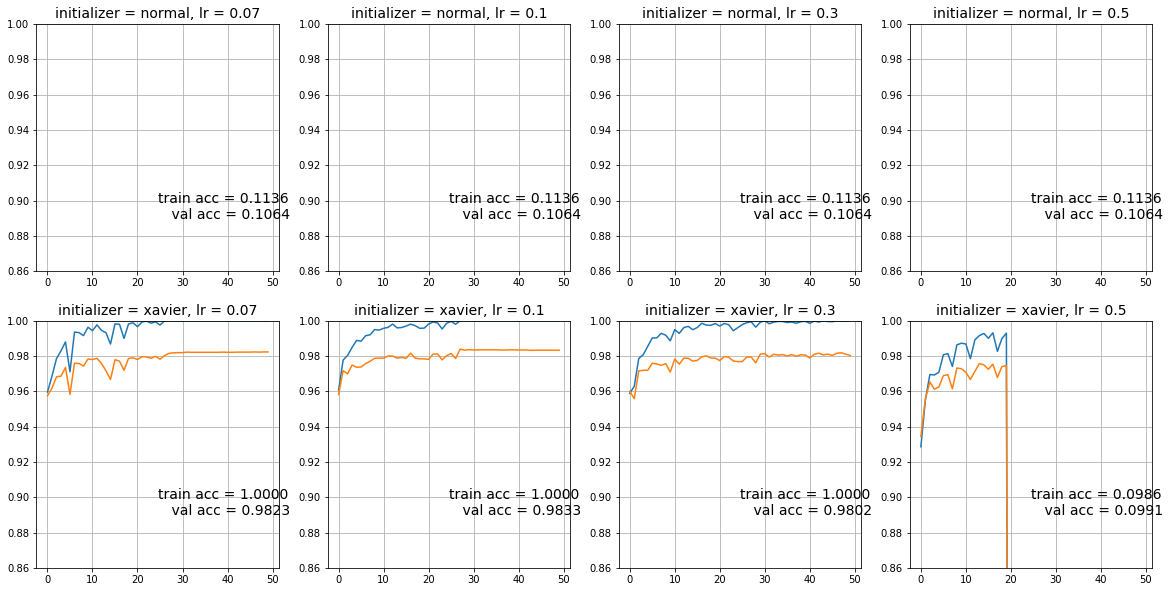

In [25]:
%%time
layer_sizes = [200] * 6

lrs = [0.07, 0.1, 0.3, 0.5]
initializers = ['normal', 'xavier']

n_epochs = 50


fig = plt.figure(figsize=(20, 10))
i = 0
for initializer, lr in itertools.product(initializers, lrs):
    i += 1
    train_log, val_log = build_and_train1(layer_sizes, initializer, lr, n_epochs)

    ax = plt.subplot(len(initializers), len(lrs), i) 
    display_learning_curve1(ax, train_log, val_log, initializer, lr)

For big networks the effect is even more pronounced: with 'normal' initialization networks do no learn at all for any learning rate, while networks with Xavier initialization show very good learning curves (last network again experienced numerical overflow) 

#### Conclusion

Xavier initialization allows networks learn faster and achieve higher accuracies compared to initialization with normal distrbution with fixed standard deviation (0.01 in our experiments). For large networks Xavier initialization even allows to succesfully train networks that do not learn at all with 'normal' initialization.

#### Option II: regularization 

In [22]:
class Dense2(Layer):
    def __init__(self, input_units, output_units, initializer='xavier', learning_rate=0.1, alpha=0):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.alpha = alpha

        # initialize weights with small random numbers. 
        if initializer == 'normal':
            self.weights = np.random.randn(input_units, output_units) * 0.01
        elif initializer == 'xavier':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(2 / (input_units + output_units))
        else:
            raise ValueError('Wrong initializer parameter')
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return input.dot(self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        grad_input = grad_output.dot(self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights - self.alpha * self.weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [23]:
def build_and_train2(layer_sizes, lr, alpha, n_epochs):
    
    print('\nTraining with and lr = {} and alpha = {} for n_epochs = {}'.format(lr, alpha, n_epochs))
    
    network = []
    network.append(Dense2(X_train.shape[1], layer_sizes[0], learning_rate=lr, alpha=alpha))
    network.append(ReLU())
    for layer in range(len(layer_sizes)-1):
        network.append(Dense2(layer_sizes[layer], layer_sizes[layer+1], learning_rate=lr, alpha=alpha))
        network.append(ReLU())
    network.append(Dense2(layer_sizes[-1], 10, learning_rate=lr, alpha=alpha))

    train_log = []
    val_log = []

    for epoch in range(n_epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
            train(network,x_batch,y_batch)

        train_log.append(np.mean(predict(network,X_train)==y_train))
        val_log.append(np.mean(predict(network,X_val)==y_val))    
        print('epoch = {:2d}, train acc = {:6.4f}, val acc = {:6.4f}'.format(epoch, train_log[-1], val_log[-1]))
        
    return train_log, val_log

def display_learning_curve2(ax, train_log, val_log, lr, alpha):
        
    ax.plot(train_log,label='train accuracy')
    ax.plot(val_log,label='val accuracy')
    ax.set_ylim(0.86, 1)
#     plt.legend(loc='best')
    ax.set_title('lr = {}, alpha = {}'.format(lr, alpha), fontsize=14)
    ax.text(0.3, 0.2, 'train acc = {:6.4f}\n   val acc = {:6.4f}'.format(train_log[-1], val_log[-1]),
            ha='left', va='bottom', fontsize=14, transform=ax.transAxes)
    ax.grid()


Training with and lr = 0.07 and alpha = 3e-05 for n_epochs = 50
epoch =  0, train acc = 0.9487, val acc = 0.9510
epoch =  1, train acc = 0.9593, val acc = 0.9565
epoch =  2, train acc = 0.9719, val acc = 0.9659
epoch =  3, train acc = 0.9780, val acc = 0.9699
epoch =  4, train acc = 0.9830, val acc = 0.9725
epoch =  5, train acc = 0.9847, val acc = 0.9716
epoch =  6, train acc = 0.9883, val acc = 0.9759
epoch =  7, train acc = 0.9890, val acc = 0.9749
epoch =  8, train acc = 0.9918, val acc = 0.9765
epoch =  9, train acc = 0.9895, val acc = 0.9749
epoch = 10, train acc = 0.9926, val acc = 0.9753
epoch = 11, train acc = 0.9933, val acc = 0.9764
epoch = 12, train acc = 0.9944, val acc = 0.9781
epoch = 13, train acc = 0.9950, val acc = 0.9785
epoch = 14, train acc = 0.9953, val acc = 0.9786
epoch = 15, train acc = 0.9968, val acc = 0.9787
epoch = 16, train acc = 0.9956, val acc = 0.9782
epoch = 17, train acc = 0.9971, val acc = 0.9795
epoch = 18, train acc = 0.9946, val acc = 0.9770
epoc

epoch = 12, train acc = 0.9930, val acc = 0.9770
epoch = 13, train acc = 0.9932, val acc = 0.9720
epoch = 14, train acc = 0.9910, val acc = 0.9731
epoch = 15, train acc = 0.9946, val acc = 0.9733
epoch = 16, train acc = 0.9905, val acc = 0.9709
epoch = 17, train acc = 0.9953, val acc = 0.9752
epoch = 18, train acc = 0.9967, val acc = 0.9780
epoch = 19, train acc = 0.9939, val acc = 0.9758
epoch = 20, train acc = 0.9940, val acc = 0.9754
epoch = 21, train acc = 0.9925, val acc = 0.9766
epoch = 22, train acc = 0.9970, val acc = 0.9761
epoch = 23, train acc = 0.9925, val acc = 0.9728
epoch = 24, train acc = 0.9759, val acc = 0.9590
epoch = 25, train acc = 0.9857, val acc = 0.9688
epoch = 26, train acc = 0.9943, val acc = 0.9759
epoch = 27, train acc = 0.9763, val acc = 0.9634
epoch = 28, train acc = 0.9916, val acc = 0.9748
epoch = 29, train acc = 0.9956, val acc = 0.9787
epoch = 30, train acc = 0.9945, val acc = 0.9757
epoch = 31, train acc = 0.9971, val acc = 0.9785
epoch = 32, train ac

epoch = 26, train acc = 0.9892, val acc = 0.9762
epoch = 27, train acc = 0.9927, val acc = 0.9778
epoch = 28, train acc = 0.9927, val acc = 0.9778
epoch = 29, train acc = 0.9929, val acc = 0.9753
epoch = 30, train acc = 0.9900, val acc = 0.9762
epoch = 31, train acc = 0.9919, val acc = 0.9779
epoch = 32, train acc = 0.9924, val acc = 0.9739
epoch = 33, train acc = 0.9911, val acc = 0.9741
epoch = 34, train acc = 0.9913, val acc = 0.9771
epoch = 35, train acc = 0.9942, val acc = 0.9786
epoch = 36, train acc = 0.9954, val acc = 0.9804
epoch = 37, train acc = 0.9875, val acc = 0.9718
epoch = 38, train acc = 0.9926, val acc = 0.9772
epoch = 39, train acc = 0.9935, val acc = 0.9777
epoch = 40, train acc = 0.9851, val acc = 0.9710
epoch = 41, train acc = 0.9945, val acc = 0.9789
epoch = 42, train acc = 0.9918, val acc = 0.9753
epoch = 43, train acc = 0.9922, val acc = 0.9764
epoch = 44, train acc = 0.9908, val acc = 0.9739
epoch = 45, train acc = 0.9932, val acc = 0.9768
epoch = 46, train ac

epoch = 40, train acc = 0.9905, val acc = 0.9769
epoch = 41, train acc = 0.9937, val acc = 0.9805
epoch = 42, train acc = 0.9924, val acc = 0.9775
epoch = 43, train acc = 0.9928, val acc = 0.9793
epoch = 44, train acc = 0.9898, val acc = 0.9765
epoch = 45, train acc = 0.9926, val acc = 0.9805
epoch = 46, train acc = 0.9852, val acc = 0.9742
epoch = 47, train acc = 0.9897, val acc = 0.9766
epoch = 48, train acc = 0.9901, val acc = 0.9792
epoch = 49, train acc = 0.9936, val acc = 0.9807

Training with and lr = 0.3 and alpha = 0.0001 for n_epochs = 50
epoch =  0, train acc = 0.9606, val acc = 0.9577
epoch =  1, train acc = 0.9760, val acc = 0.9704
epoch =  2, train acc = 0.9716, val acc = 0.9611
epoch =  3, train acc = 0.9814, val acc = 0.9687
epoch =  4, train acc = 0.9839, val acc = 0.9708
epoch =  5, train acc = 0.9882, val acc = 0.9762
epoch =  6, train acc = 0.9909, val acc = 0.9764
epoch =  7, train acc = 0.9883, val acc = 0.9754
epoch =  8, train acc = 0.9783, val acc = 0.9660
epoc

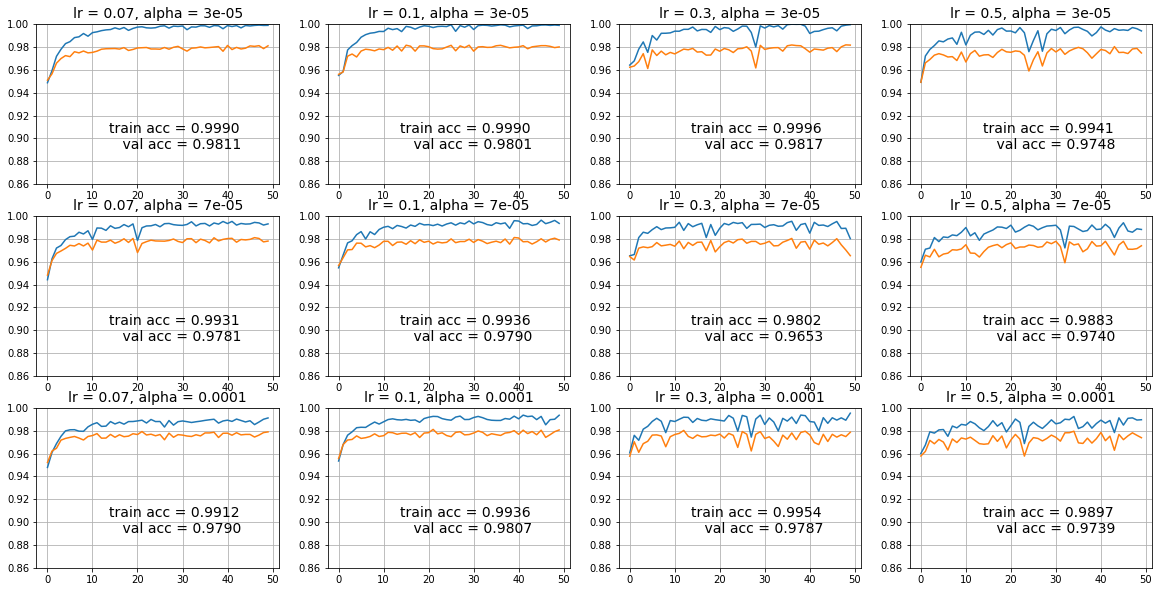

In [28]:
%%time
layer_sizes = [100, 200]

lrs = [0.07, 0.1, 0.3, 0.5]
alphas = [3e-5, 7e-5, 1e-4]

n_epochs = 50


fig = plt.figure(figsize=(20, 10))
i = 0
for alpha, lr in itertools.product(alphas, lrs):
    i += 1
    train_log, val_log = build_and_train2(layer_sizes, lr, alpha, n_epochs)

    ax = plt.subplot(len(alphas), len(lrs), i) 
    display_learning_curve2(ax, train_log, val_log, lr, alpha)


Training with and lr = 0.07 and alpha = 3e-05 for n_epochs = 50
epoch =  0, train acc = 0.9563, val acc = 0.9578
epoch =  1, train acc = 0.9713, val acc = 0.9664
epoch =  2, train acc = 0.9806, val acc = 0.9724
epoch =  3, train acc = 0.9833, val acc = 0.9723
epoch =  4, train acc = 0.9874, val acc = 0.9751
epoch =  5, train acc = 0.9922, val acc = 0.9777
epoch =  6, train acc = 0.9932, val acc = 0.9791
epoch =  7, train acc = 0.9913, val acc = 0.9770
epoch =  8, train acc = 0.9924, val acc = 0.9782
epoch =  9, train acc = 0.9954, val acc = 0.9794
epoch = 10, train acc = 0.9958, val acc = 0.9790
epoch = 11, train acc = 0.9960, val acc = 0.9787
epoch = 12, train acc = 0.9978, val acc = 0.9800
epoch = 13, train acc = 0.9959, val acc = 0.9788
epoch = 14, train acc = 0.9976, val acc = 0.9800
epoch = 15, train acc = 0.9933, val acc = 0.9758
epoch = 16, train acc = 0.9987, val acc = 0.9801
epoch = 17, train acc = 0.9975, val acc = 0.9790
epoch = 18, train acc = 0.9984, val acc = 0.9796
epoc

epoch = 12, train acc = 0.9867, val acc = 0.9719
epoch = 13, train acc = 0.9899, val acc = 0.9740
epoch = 14, train acc = 0.9906, val acc = 0.9760
epoch = 15, train acc = 0.9894, val acc = 0.9750
epoch = 16, train acc = 0.9914, val acc = 0.9753
epoch = 17, train acc = 0.9741, val acc = 0.9582
epoch = 18, train acc = 0.9344, val acc = 0.9158
epoch = 19, train acc = 0.9916, val acc = 0.9737
epoch = 20, train acc = 0.9939, val acc = 0.9763
epoch = 21, train acc = 0.9910, val acc = 0.9727
epoch = 22, train acc = 0.9809, val acc = 0.9644
epoch = 23, train acc = 0.9926, val acc = 0.9717
epoch = 24, train acc = 0.9928, val acc = 0.9733
epoch = 25, train acc = 0.9923, val acc = 0.9745
epoch = 26, train acc = 0.9920, val acc = 0.9750
epoch = 27, train acc = 0.9923, val acc = 0.9761
epoch = 28, train acc = 0.9937, val acc = 0.9764
epoch = 29, train acc = 0.9885, val acc = 0.9713
epoch = 30, train acc = 0.9952, val acc = 0.9769
epoch = 31, train acc = 0.9938, val acc = 0.9753
epoch = 32, train ac

epoch = 26, train acc = 0.9892, val acc = 0.9738
epoch = 27, train acc = 0.9856, val acc = 0.9719
epoch = 28, train acc = 0.9929, val acc = 0.9791
epoch = 29, train acc = 0.9893, val acc = 0.9774
epoch = 30, train acc = 0.9888, val acc = 0.9748
epoch = 31, train acc = 0.9938, val acc = 0.9793
epoch = 32, train acc = 0.9881, val acc = 0.9743
epoch = 33, train acc = 0.9894, val acc = 0.9729
epoch = 34, train acc = 0.9911, val acc = 0.9766
epoch = 35, train acc = 0.9951, val acc = 0.9801
epoch = 36, train acc = 0.9931, val acc = 0.9793
epoch = 37, train acc = 0.9931, val acc = 0.9756
epoch = 38, train acc = 0.9933, val acc = 0.9810
epoch = 39, train acc = 0.9921, val acc = 0.9784
epoch = 40, train acc = 0.9881, val acc = 0.9738
epoch = 41, train acc = 0.9911, val acc = 0.9771
epoch = 42, train acc = 0.9894, val acc = 0.9721
epoch = 43, train acc = 0.9925, val acc = 0.9789
epoch = 44, train acc = 0.9918, val acc = 0.9774
epoch = 45, train acc = 0.9910, val acc = 0.9740
epoch = 46, train ac

epoch = 40, train acc = 0.9909, val acc = 0.9765
epoch = 41, train acc = 0.9750, val acc = 0.9614
epoch = 42, train acc = 0.9914, val acc = 0.9766
epoch = 43, train acc = 0.9873, val acc = 0.9741
epoch = 44, train acc = 0.9909, val acc = 0.9772
epoch = 45, train acc = 0.9897, val acc = 0.9748
epoch = 46, train acc = 0.9913, val acc = 0.9776
epoch = 47, train acc = 0.9929, val acc = 0.9778
epoch = 48, train acc = 0.9931, val acc = 0.9783
epoch = 49, train acc = 0.9890, val acc = 0.9755

Training with and lr = 0.3 and alpha = 0.0001 for n_epochs = 50
epoch =  0, train acc = 0.9594, val acc = 0.9575
epoch =  1, train acc = 0.9680, val acc = 0.9597
epoch =  2, train acc = 0.9781, val acc = 0.9692
epoch =  3, train acc = 0.9833, val acc = 0.9714
epoch =  4, train acc = 0.9848, val acc = 0.9724
epoch =  5, train acc = 0.9772, val acc = 0.9689
epoch =  6, train acc = 0.9811, val acc = 0.9685
epoch =  7, train acc = 0.9872, val acc = 0.9753
epoch =  8, train acc = 0.9847, val acc = 0.9729
epoc

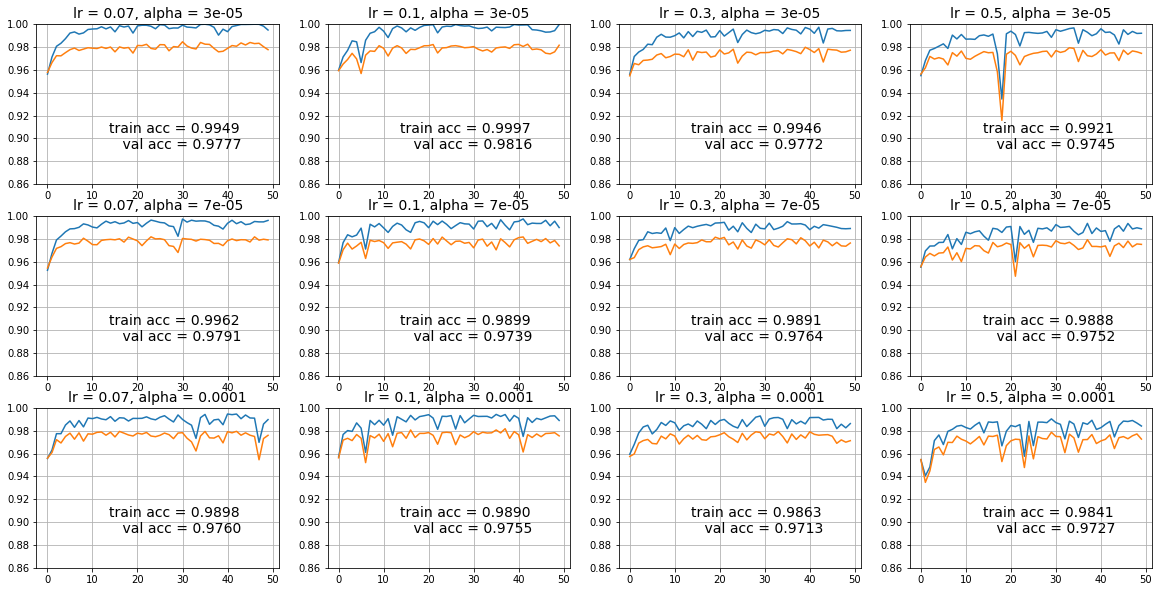

In [24]:
%%time
layer_sizes = [200] * 4

lrs = [0.07, 0.1, 0.3, 0.5]
alphas = [3e-5, 7e-5, 1e-4]

n_epochs = 50


fig = plt.figure(figsize=(20, 10))
i = 0
for alpha, lr in itertools.product(alphas, lrs):
    i += 1
    train_log, val_log = build_and_train2(layer_sizes, lr, alpha, n_epochs)

    ax = plt.subplot(len(alphas), len(lrs), i) 
    display_learning_curve2(ax, train_log, val_log, lr, alpha)


Training with and lr = 0.07 and alpha = 3e-05 for n_epochs = 50
epoch =  0, train acc = 0.9594, val acc = 0.9572
epoch =  1, train acc = 0.9706, val acc = 0.9659
epoch =  2, train acc = 0.9793, val acc = 0.9726
epoch =  3, train acc = 0.9846, val acc = 0.9723
epoch =  4, train acc = 0.9894, val acc = 0.9761
epoch =  5, train acc = 0.9802, val acc = 0.9683
epoch =  6, train acc = 0.9902, val acc = 0.9732
epoch =  7, train acc = 0.9877, val acc = 0.9726
epoch =  8, train acc = 0.9950, val acc = 0.9791
epoch =  9, train acc = 0.9925, val acc = 0.9761
epoch = 10, train acc = 0.9942, val acc = 0.9771
epoch = 11, train acc = 0.9932, val acc = 0.9748
epoch = 12, train acc = 0.9931, val acc = 0.9764
epoch = 13, train acc = 0.9972, val acc = 0.9793
epoch = 14, train acc = 0.9968, val acc = 0.9802
epoch = 15, train acc = 0.9961, val acc = 0.9781
epoch = 16, train acc = 0.9906, val acc = 0.9740
epoch = 17, train acc = 0.9977, val acc = 0.9796
epoch = 18, train acc = 0.9980, val acc = 0.9808
epoc

epoch = 12, train acc = 0.9847, val acc = 0.9709
epoch = 13, train acc = 0.9841, val acc = 0.9714
epoch = 14, train acc = 0.9812, val acc = 0.9678
epoch = 15, train acc = 0.9863, val acc = 0.9720
epoch = 16, train acc = 0.9903, val acc = 0.9739
epoch = 17, train acc = 0.9798, val acc = 0.9635
epoch = 18, train acc = 0.9893, val acc = 0.9736
epoch = 19, train acc = 0.9841, val acc = 0.9670
epoch = 20, train acc = 0.9888, val acc = 0.9743
epoch = 21, train acc = 0.9907, val acc = 0.9735
epoch = 22, train acc = 0.9901, val acc = 0.9731
epoch = 23, train acc = 0.9524, val acc = 0.9352
epoch = 24, train acc = 0.9887, val acc = 0.9732
epoch = 25, train acc = 0.9800, val acc = 0.9656
epoch = 26, train acc = 0.9800, val acc = 0.9652
epoch = 27, train acc = 0.9888, val acc = 0.9701
epoch = 28, train acc = 0.9877, val acc = 0.9715
epoch = 29, train acc = 0.9777, val acc = 0.9669
epoch = 30, train acc = 0.9914, val acc = 0.9736
epoch = 31, train acc = 0.9897, val acc = 0.9743
epoch = 32, train ac

epoch = 26, train acc = 0.9756, val acc = 0.9638
epoch = 27, train acc = 0.9651, val acc = 0.9508
epoch = 28, train acc = 0.9911, val acc = 0.9762
epoch = 29, train acc = 0.9837, val acc = 0.9719
epoch = 30, train acc = 0.9826, val acc = 0.9660
epoch = 31, train acc = 0.9922, val acc = 0.9779
epoch = 32, train acc = 0.9915, val acc = 0.9792
epoch = 33, train acc = 0.9920, val acc = 0.9795
epoch = 34, train acc = 0.9822, val acc = 0.9716
epoch = 35, train acc = 0.9894, val acc = 0.9731
epoch = 36, train acc = 0.9938, val acc = 0.9783
epoch = 37, train acc = 0.9939, val acc = 0.9766
epoch = 38, train acc = 0.9768, val acc = 0.9641
epoch = 39, train acc = 0.9931, val acc = 0.9786
epoch = 40, train acc = 0.9916, val acc = 0.9776
epoch = 41, train acc = 0.9898, val acc = 0.9753
epoch = 42, train acc = 0.9865, val acc = 0.9708
epoch = 43, train acc = 0.9841, val acc = 0.9680
epoch = 44, train acc = 0.9795, val acc = 0.9655
epoch = 45, train acc = 0.9919, val acc = 0.9772
epoch = 46, train ac

epoch = 40, train acc = 0.9928, val acc = 0.9777
epoch = 41, train acc = 0.9883, val acc = 0.9712
epoch = 42, train acc = 0.9893, val acc = 0.9752
epoch = 43, train acc = 0.9900, val acc = 0.9755
epoch = 44, train acc = 0.9912, val acc = 0.9772
epoch = 45, train acc = 0.9916, val acc = 0.9763
epoch = 46, train acc = 0.9913, val acc = 0.9798
epoch = 47, train acc = 0.9901, val acc = 0.9795
epoch = 48, train acc = 0.9864, val acc = 0.9721
epoch = 49, train acc = 0.9926, val acc = 0.9805

Training with and lr = 0.3 and alpha = 0.0001 for n_epochs = 50
epoch =  0, train acc = 0.9559, val acc = 0.9555
epoch =  1, train acc = 0.9614, val acc = 0.9559
epoch =  2, train acc = 0.9651, val acc = 0.9620
epoch =  3, train acc = 0.9764, val acc = 0.9680
epoch =  4, train acc = 0.9783, val acc = 0.9708
epoch =  5, train acc = 0.9656, val acc = 0.9620
epoch =  6, train acc = 0.9777, val acc = 0.9701
epoch =  7, train acc = 0.9779, val acc = 0.9683
epoch =  8, train acc = 0.9829, val acc = 0.9745
epoc

/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/yuri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


epoch =  0, train acc = 0.0986, val acc = 0.0991
epoch =  1, train acc = 0.0986, val acc = 0.0991
epoch =  2, train acc = 0.0986, val acc = 0.0991
epoch =  3, train acc = 0.0986, val acc = 0.0991
epoch =  4, train acc = 0.0986, val acc = 0.0991
epoch =  5, train acc = 0.0986, val acc = 0.0991
epoch =  6, train acc = 0.0986, val acc = 0.0991
epoch =  7, train acc = 0.0986, val acc = 0.0991
epoch =  8, train acc = 0.0986, val acc = 0.0991
epoch =  9, train acc = 0.0986, val acc = 0.0991
epoch = 10, train acc = 0.0986, val acc = 0.0991
epoch = 11, train acc = 0.0986, val acc = 0.0991
epoch = 12, train acc = 0.0986, val acc = 0.0991
epoch = 13, train acc = 0.0986, val acc = 0.0991
epoch = 14, train acc = 0.0986, val acc = 0.0991
epoch = 15, train acc = 0.0986, val acc = 0.0991
epoch = 16, train acc = 0.0986, val acc = 0.0991
epoch = 17, train acc = 0.0986, val acc = 0.0991
epoch = 18, train acc = 0.0986, val acc = 0.0991
epoch = 19, train acc = 0.0986, val acc = 0.0991
epoch = 20, train ac

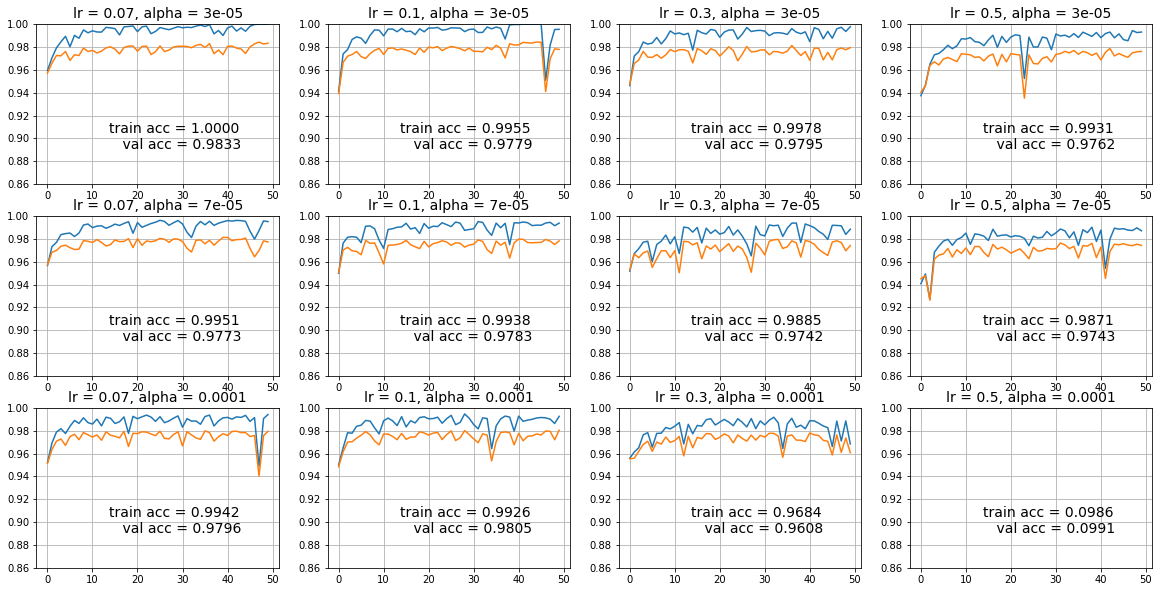

In [25]:
%%time
layer_sizes = [200] * 6

lrs = [0.07, 0.1, 0.3, 0.5]
alphas = [3e-5, 7e-5, 1e-4]

n_epochs = 50


fig = plt.figure(figsize=(20, 10))
i = 0
for alpha, lr in itertools.product(alphas, lrs):
    i += 1
    train_log, val_log = build_and_train2(layer_sizes, lr, alpha, n_epochs)

    ax = plt.subplot(len(alphas), len(lrs), i) 
    display_learning_curve2(ax, train_log, val_log, lr, alpha)

rerun with no lr = 0.5 and with alpha = 0.003 or higher

#### Option III: 

In [91]:
class Dense3(Layer):
    def __init__(self, input_units, output_units, alpha=0,
                 initializer='xavier', optimizer='adam', learning_rate=0.1, beta1=0.9, beta2=0.99):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.alpha = alpha
        
        # initialize weights with small random numbers. 
        if initializer == 'normal':
            self.weights = np.random.randn(input_units, output_units) * 0.01
        elif initializer == 'xavier':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(2 / (input_units + output_units))
        else:
            raise ValueError('Wrong initializer parameter')
        self.biases = np.zeros(output_units)
        
        
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        if self.optimizer == 'momentum':
            self.beta1 = beta1
            self.momentum_weights = np.zeros_like(self.weights)
            self.momentum_biases = np.zeros_like(self.biases)        
        elif self.optimizer == 'rmsprop':
            self.beta2 = beta2
            self.epsilon=1e-08
            self.momentum_weights2 = np.zeros_like(self.weights)
            self.momentum_biases2 = np.zeros_like(self.biases)     
        elif self.optimizer == 'adam':
            self.beta1 = beta1
            self.beta2 = beta2
            self.epsilon=1e-08
            
            self.n_iterations = 0
            self.momentum_weights = np.zeros_like(self.weights)
            self.momentum_biases = np.zeros_like(self.biases)
            self.momentum_weights2 = np.zeros_like(self.weights)
            self.momentum_biases2 = np.zeros_like(self.biases)

        
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return input.dot(self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute input gradient
        grad_input = grad_output.dot(self.weights.T)
        
        # compute parameter gradient
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        # add L2 regularization
        grad_weights += self.alpha * self.weights
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # optimization 
        if self.optimizer == 'sgd':
            self.weights -= self.learning_rate * grad_weights
            self.biases -= self.learning_rate * grad_biases
        
        elif self.optimizer == 'momentum':
            self.momentum_weights = self.beta1 * self.momentum_weights + (1 - self.beta1) * grad_weights
            self.momentum_biases = self.beta1 * self.momentum_biases + (1 - self.beta1) * grad_biases

            self.weights -= self.learning_rate * self.momentum_weights
            self.biases -= self.learning_rate * self.momentum_biases
            
        elif self.optimizer == 'rmsprop':
            self.momentum_weights2 = self.beta2 * self.momentum_weights2 + (1 - self.beta2) * grad_weights ** 2
            self.momentum_biases2 = self.beta2 * self.momentum_biases2 + (1 - self.beta2) * grad_biases ** 2

            self.weights -= self.learning_rate * grad_weights / (np.sqrt(self.momentum_weights2) + self.epsilon)
            self.biases -= self.learning_rate * grad_biases / (np.sqrt(self.momentum_biases2) + self.epsilon)

        elif self.optimizer == 'adam':
            self.n_iterations += 1
            
            self.momentum_weights = self.beta1 * self.momentum_weights + (1 - self.beta1) * grad_weights
            self.momentum_biases = self.beta1 * self.momentum_biases + (1 - self.beta1) * grad_biases
            self.momentum_weights2 = self.beta2 * self.momentum_weights2 + (1 - self.beta2) * grad_weights ** 2
            self.momentum_biases2 = self.beta2 * self.momentum_biases2 + (1 - self.beta2) * grad_biases ** 2
            
            momentum_weights_corr = self.momentum_weights / (1 - beta1 ** self.n_iterations)
            momentum_biases_corr = self.momentum_biases / (1 - beta1 ** self.n_iterations)
            
            momentum_weights2_corr = self.momentum_weights2 / (1 - beta2 ** self.n_iterations)
            momentum_biases2_corr = self.momentum_biases2 / (1 - beta2 ** self.n_iterations)

            self.weights -= self.learning_rate * momentum_weights_corr / (np.sqrt(momentum_weights2_corr) + self.epsilon)
            self.biases -= self.learning_rate * momentum_biases_corr / (np.sqrt(momentum_biases2_corr) + self.epsilon)
   
            
        return grad_input

In [301]:
def build_and_train3(layer_sizes, alpha, optimizer, lr, beta1, beta2, n_epochs):
    
    
    print('\nTraining with alpha = {}, optimizer = {}, lr = {}, beta1 = {} and beta2 = {} for n_epochs = {}'.format(
        alpha, optimizer, lr, beta1, beta2, n_epochs))
    
    network = []
    network.append(Dense3(X_train.shape[1], layer_sizes[0], alpha=alpha,
            optimizer=optimizer, learning_rate=lr, beta1=beta1, beta2=beta2))
    network.append(ReLU())
    for layer in range(len(layer_sizes)-1):
        network.append(Dense3(layer_sizes[layer], layer_sizes[layer+1], alpha=alpha,
            optimizer=optimizer, learning_rate=lr, beta1=beta1, beta2=beta2))
        network.append(ReLU())
    network.append(Dense3(layer_sizes[-1], 10, alpha=alpha,
            optimizer=optimizer, learning_rate=lr, beta1=beta1, beta2=beta2))

    loss_train_log = []
    loss_train = 0
    acc_train_log = []
    acc_val_log = []

    for epoch in range(n_epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
            loss_train_new = train(network,x_batch,y_batch)
            loss_train = 0.95 * loss_train + 0.1 * loss_train_new
        
        loss_train_log.append(loss_train)
        acc_train_log.append(np.mean(predict(network,X_train)==y_train))
        acc_val_log.append(np.mean(predict(network,X_val)==y_val))    
        print('epoch = {:2d}, train loss = {:6.4f}, train acc = {:6.4f}, val acc = {:6.4f}'.format(
            epoch, loss_train_log[-1], acc_train_log[-1], acc_val_log[-1]))
        
    return loss_train_log, acc_train_log, acc_val_log

def display_learning_curve3(ax, loss_train_log, acc_train_log, acc_val_log, alpha, optimizer, lr, beta1, beta2):
        
    ax.plot(loss_train_log / min(loss_train_log) - 0.14 , label='train loss')
    ax.plot(acc_train_log, label='train accuracy')
    ax.plot(acc_val_log, label='val accuracy')
    ax.set_ylim(0.86, 1)
#     plt.legend(loc='best')
    ax.set_title('alpha={}, opt={},\nlr={}, beta1={}, beta2={}'.format(alpha, optimizer, lr, beta1, beta2),
                 fontsize=14)
    ax.text(0.3, 0.2, 'train loss = {:6.4f}\n train acc = {:6.4f}\n    val acc = {:6.4f}'.format(
        loss_train_log[-1], acc_train_log[-1], acc_val_log[-1]),
            ha='left', va='bottom', fontsize=14, transform=ax.transAxes)
    ax.grid()
    plt.tight_layout()


Training with alpha = 0, optimizer = sgd, lr = 0.07, beta1 = None and beta2 = None for n_epochs = 50
epoch =  0, train loss = 0.3773, train acc = 0.9508, val acc = 0.9540
epoch =  1, train loss = 0.2274, train acc = 0.9682, val acc = 0.9657
epoch =  2, train loss = 0.2183, train acc = 0.9770, val acc = 0.9706
epoch =  3, train loss = 0.1776, train acc = 0.9821, val acc = 0.9734
epoch =  4, train loss = 0.1340, train acc = 0.9851, val acc = 0.9740
epoch =  5, train loss = 0.1038, train acc = 0.9869, val acc = 0.9745
epoch =  6, train loss = 0.0862, train acc = 0.9880, val acc = 0.9734
epoch =  7, train loss = 0.1148, train acc = 0.9905, val acc = 0.9755
epoch =  8, train loss = 0.0692, train acc = 0.9925, val acc = 0.9758
epoch =  9, train loss = 0.0803, train acc = 0.9956, val acc = 0.9784
epoch = 10, train loss = 0.0538, train acc = 0.9945, val acc = 0.9758
epoch = 11, train loss = 0.0479, train acc = 0.9953, val acc = 0.9763
epoch = 12, train loss = 0.0607, train acc = 0.9977, val a

epoch = 13, train loss = 0.0301, train acc = 0.9971, val acc = 0.9772
epoch = 14, train loss = 0.0557, train acc = 0.9887, val acc = 0.9653
epoch = 15, train loss = 0.0149, train acc = 0.9982, val acc = 0.9788
epoch = 16, train loss = 0.0345, train acc = 0.9961, val acc = 0.9769
epoch = 17, train loss = 0.0171, train acc = 0.9980, val acc = 0.9782
epoch = 18, train loss = 0.0074, train acc = 0.9992, val acc = 0.9804
epoch = 19, train loss = 0.0009, train acc = 0.9999, val acc = 0.9817
epoch = 20, train loss = 0.0008, train acc = 1.0000, val acc = 0.9813
epoch = 21, train loss = 0.0002, train acc = 1.0000, val acc = 0.9819
epoch = 22, train loss = 0.0002, train acc = 1.0000, val acc = 0.9819
epoch = 23, train loss = 0.0001, train acc = 1.0000, val acc = 0.9822
epoch = 24, train loss = 0.0002, train acc = 1.0000, val acc = 0.9823
epoch = 25, train loss = 0.0001, train acc = 1.0000, val acc = 0.9821
epoch = 26, train loss = 0.0001, train acc = 1.0000, val acc = 0.9822
epoch = 27, train lo

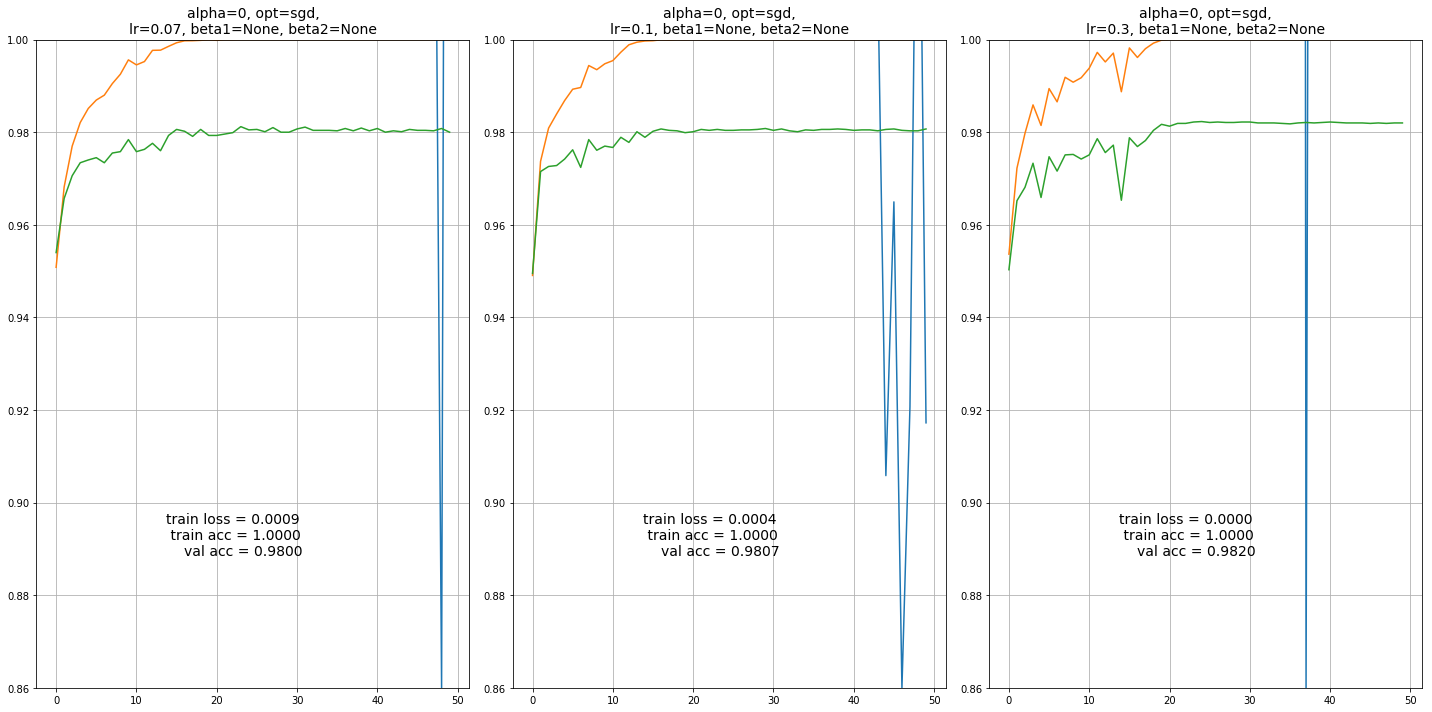

In [307]:
%%time
layer_sizes = [100, 200]

alpha = 0

optimizer = 'sgd'
lrs = [0.07, 0.1, 0.3]
beta1 = None
beta2 = None

n_epochs = 50


fig = plt.figure(figsize=(20, 10))
i = 0
for lr in lrs:
    i += 1
    loss_train_log, acc_train_log, acc_val_log = build_and_train3(layer_sizes, alpha=alpha,
                                          optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2, n_epochs=n_epochs)

    ax = plt.subplot(1, len(lrs), i) 
    display_learning_curve3(ax, loss_train_log, acc_train_log, acc_val_log, alpha=alpha,
                            optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2)


Training with alpha = 0, optimizer = momentum, lr = 0.07, beta1 = 0.87 and beta2 = None for n_epochs = 50
epoch =  0, train loss = 0.3898, train acc = 0.9460, val acc = 0.9483
epoch =  1, train loss = 0.2859, train acc = 0.9658, val acc = 0.9655
epoch =  2, train loss = 0.2087, train acc = 0.9736, val acc = 0.9654
epoch =  3, train loss = 0.1603, train acc = 0.9823, val acc = 0.9722
epoch =  4, train loss = 0.1393, train acc = 0.9825, val acc = 0.9721
epoch =  5, train loss = 0.1017, train acc = 0.9839, val acc = 0.9715
epoch =  6, train loss = 0.1119, train acc = 0.9911, val acc = 0.9766
epoch =  7, train loss = 0.0600, train acc = 0.9912, val acc = 0.9745
epoch =  8, train loss = 0.0576, train acc = 0.9933, val acc = 0.9739
epoch =  9, train loss = 0.0771, train acc = 0.9903, val acc = 0.9724
epoch = 10, train loss = 0.0384, train acc = 0.9970, val acc = 0.9787
epoch = 11, train loss = 0.0453, train acc = 0.9959, val acc = 0.9769
epoch = 12, train loss = 0.0236, train acc = 0.9982, 

epoch = 13, train loss = 0.0322, train acc = 0.9971, val acc = 0.9789
epoch = 14, train loss = 0.0557, train acc = 0.9895, val acc = 0.9675
epoch = 15, train loss = 0.0241, train acc = 0.9980, val acc = 0.9779
epoch = 16, train loss = 0.0150, train acc = 0.9987, val acc = 0.9792
epoch = 17, train loss = 0.0058, train acc = 0.9997, val acc = 0.9799
epoch = 18, train loss = 0.0006, train acc = 0.9999, val acc = 0.9817
epoch = 19, train loss = 0.0004, train acc = 1.0000, val acc = 0.9814
epoch = 20, train loss = 0.0002, train acc = 1.0000, val acc = 0.9822
epoch = 21, train loss = 0.0003, train acc = 1.0000, val acc = 0.9819
epoch = 22, train loss = 0.0002, train acc = 1.0000, val acc = 0.9819
epoch = 23, train loss = 0.0001, train acc = 1.0000, val acc = 0.9818
epoch = 24, train loss = 0.0001, train acc = 1.0000, val acc = 0.9820
epoch = 25, train loss = 0.0001, train acc = 1.0000, val acc = 0.9817
epoch = 26, train loss = 0.0001, train acc = 1.0000, val acc = 0.9817
epoch = 27, train lo

epoch = 28, train loss = 0.0011, train acc = 1.0000, val acc = 0.9818
epoch = 29, train loss = 0.0010, train acc = 1.0000, val acc = 0.9815
epoch = 30, train loss = 0.0008, train acc = 1.0000, val acc = 0.9821
epoch = 31, train loss = 0.0007, train acc = 1.0000, val acc = 0.9817
epoch = 32, train loss = 0.0006, train acc = 1.0000, val acc = 0.9817
epoch = 33, train loss = 0.0006, train acc = 1.0000, val acc = 0.9817
epoch = 34, train loss = 0.0007, train acc = 1.0000, val acc = 0.9817
epoch = 35, train loss = 0.0007, train acc = 1.0000, val acc = 0.9820
epoch = 36, train loss = 0.0008, train acc = 1.0000, val acc = 0.9819
epoch = 37, train loss = 0.0007, train acc = 1.0000, val acc = 0.9817
epoch = 38, train loss = 0.0005, train acc = 1.0000, val acc = 0.9820
epoch = 39, train loss = 0.0004, train acc = 1.0000, val acc = 0.9817
epoch = 40, train loss = 0.0007, train acc = 1.0000, val acc = 0.9817
epoch = 41, train loss = 0.0005, train acc = 1.0000, val acc = 0.9818
epoch = 42, train lo

epoch = 43, train loss = 0.0010, train acc = 1.0000, val acc = 0.9794
epoch = 44, train loss = 0.0008, train acc = 1.0000, val acc = 0.9797
epoch = 45, train loss = 0.0008, train acc = 1.0000, val acc = 0.9800
epoch = 46, train loss = 0.0008, train acc = 1.0000, val acc = 0.9797
epoch = 47, train loss = 0.0008, train acc = 1.0000, val acc = 0.9794
epoch = 48, train loss = 0.0006, train acc = 1.0000, val acc = 0.9795
epoch = 49, train loss = 0.0007, train acc = 1.0000, val acc = 0.9793

Training with alpha = 0, optimizer = momentum, lr = 0.1, beta1 = 0.93 and beta2 = None for n_epochs = 50
epoch =  0, train loss = 0.2974, train acc = 0.9575, val acc = 0.9572
epoch =  1, train loss = 0.2371, train acc = 0.9656, val acc = 0.9589
epoch =  2, train loss = 0.1413, train acc = 0.9793, val acc = 0.9715
epoch =  3, train loss = 0.1267, train acc = 0.9832, val acc = 0.9721
epoch =  4, train loss = 0.1671, train acc = 0.9867, val acc = 0.9737
epoch =  5, train loss = 0.0976, train acc = 0.9900, v

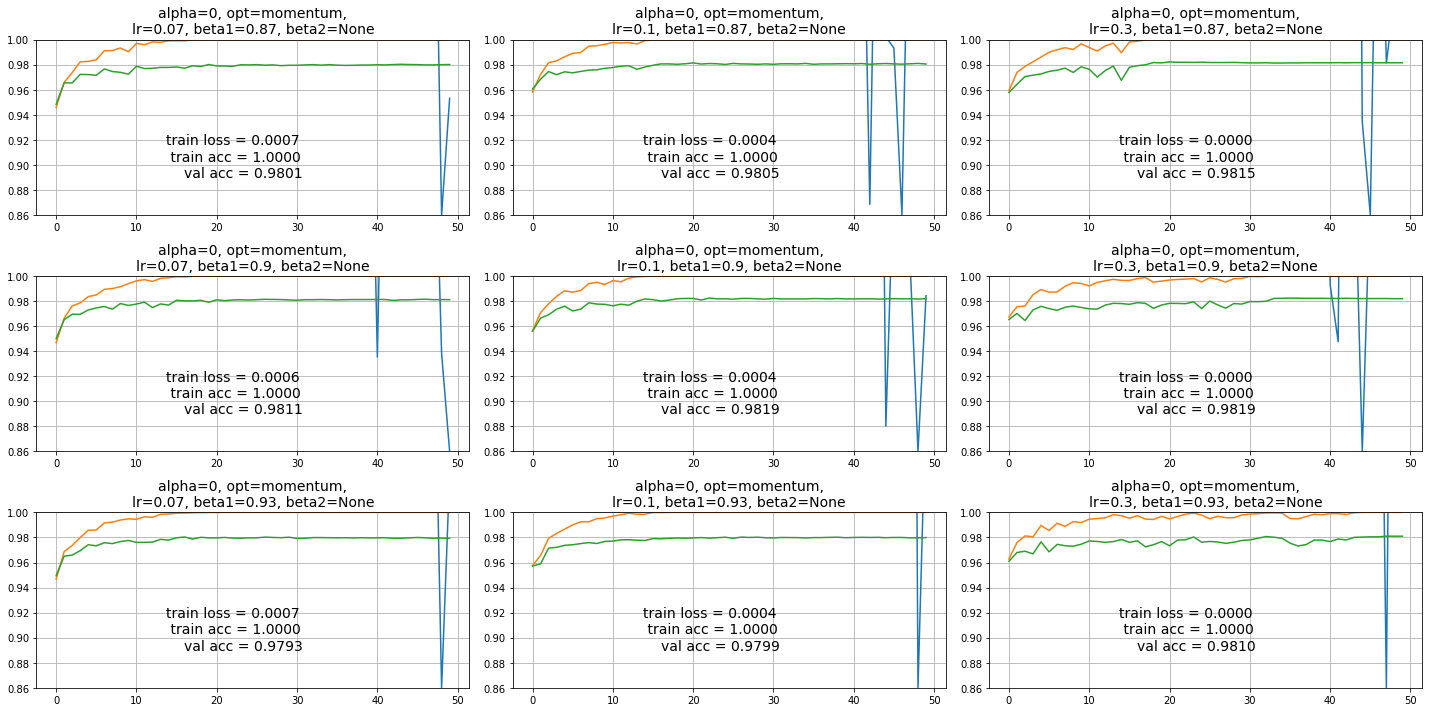

In [308]:
%%time
layer_sizes = [100, 200]

optimizer = 'momentum'
lrs = [0.07, 0.1, 0.3]
beta1s = [0.87, 0.9, 0.93]
beta2 = None
alpha = 0

n_epochs = 50


fig = plt.figure(figsize=(20, 10))
i = 0
for beta1, lr in itertools.product(beta1s, lrs):
    i += 1
    loss_train_log, acc_train_log, acc_val_log = build_and_train3(layer_sizes, alpha=alpha,
                                          optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2, n_epochs=n_epochs)

#     train_log, val_log = (0.93, 0.94, 0.95), (0.925, 0.935, 0.945 )

    ax = plt.subplot(len(beta1s), len(lrs), i)     
    display_learning_curve3(ax, loss_train_log, acc_train_log, acc_val_log, alpha=alpha,
                            optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2)

In [ ]:
%%time
layer_sizes = [100, 200]

optimizer = 'rmsprop'
lrs = [0.0007, 0.001, 0.003]
beta1 = None
beta2s = [0.87, 0.90, 0.93]
alpha = 0

n_epochs = 50

fig = plt.figure(figsize=(20, 10))
i = 0
for beta2, lr in itertools.product(beta2s, lrs):
    i += 1
    loss_train_log, acc_train_log, acc_val_log = build_and_train3(layer_sizes, alpha=alpha,
                                          optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2, n_epochs=n_epochs)

    ax = plt.subplot(len(beta1s), len(lrs), i)     
    display_learning_curve3(ax, loss_train_log, acc_train_log, acc_val_log, alpha=alpha,
                            optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2)


Training with alpha = 0, optimizer = rmsprop, lr = 0.0007, beta1 = None and beta2 = 0.87 for n_epochs = 50
epoch =  0, train loss = 0.3318, train acc = 0.9575, val acc = 0.9593
epoch =  1, train loss = 0.2023, train acc = 0.9749, val acc = 0.9705
epoch =  2, train loss = 0.2263, train acc = 0.9761, val acc = 0.9693
epoch =  3, train loss = 0.1616, train acc = 0.9855, val acc = 0.9750
epoch =  4, train loss = 0.1209, train acc = 0.9859, val acc = 0.9745
epoch =  5, train loss = 0.1032, train acc = 0.9885, val acc = 0.9757
epoch =  6, train loss = 0.1147, train acc = 0.9907, val acc = 0.9748
epoch =  7, train loss = 0.1677, train acc = 0.9894, val acc = 0.9737
epoch =  8, train loss = 0.0708, train acc = 0.9922, val acc = 0.9753
epoch =  9, train loss = 0.0492, train acc = 0.9914, val acc = 0.9746
epoch = 10, train loss = 0.0377, train acc = 0.9946, val acc = 0.9769
epoch = 11, train loss = 0.0504, train acc = 0.9953, val acc = 0.9776
epoch = 12, train loss = 0.0526, train acc = 0.9960,